In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("titanic.csv")

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
cols=["PassengerId","Cabin","Name","Ticket"]
data=data.drop(columns=cols)

In [6]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

In [7]:
data['Age'].fillna(data.groupby(['Sex', 'Pclass'])['Age'].transform('median'), inplace=True)

In [8]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False)

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [9]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if (self.columns is None):
            num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
            self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [10]:
X = data.drop(['Survived'], axis = 1)
y = data['Survived']

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
pipe = Pipeline([
    ('oneHot',oneHot(columns=['Embarked','Pclass','Sex'])),
    ('scaler',StdScaler())
])

In [13]:
X_train = pipe.fit_transform(x_train.copy())
X_test = pipe.fit_transform(x_test.copy())

## Bias Detection

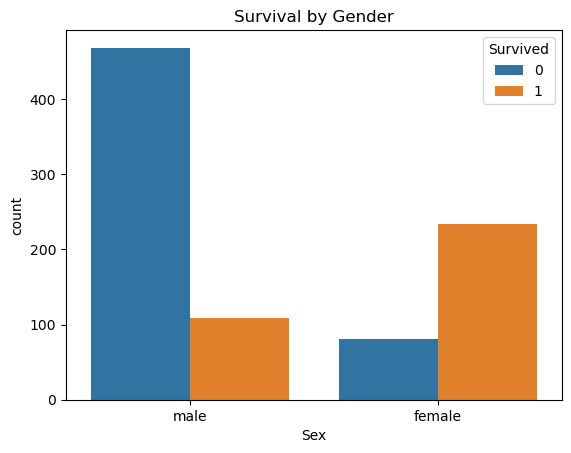

In [14]:
sns.countplot(x='Sex', hue='Survived', data=X.join(y))
plt.title('Survival by Gender')
plt.show()


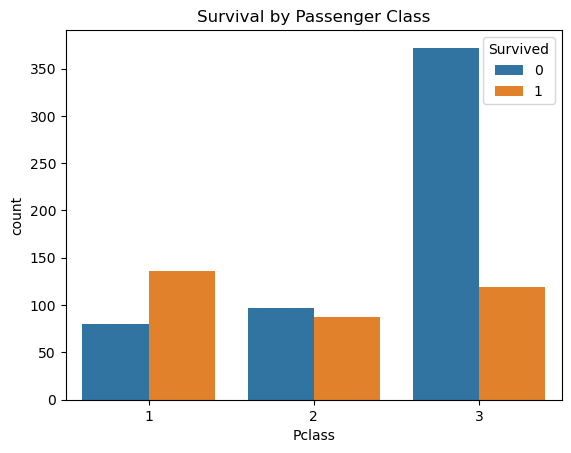

In [15]:
sns.countplot(x='Pclass', hue='Survived', data=X.join(y))
plt.title('Survival by Passenger Class')
plt.show()


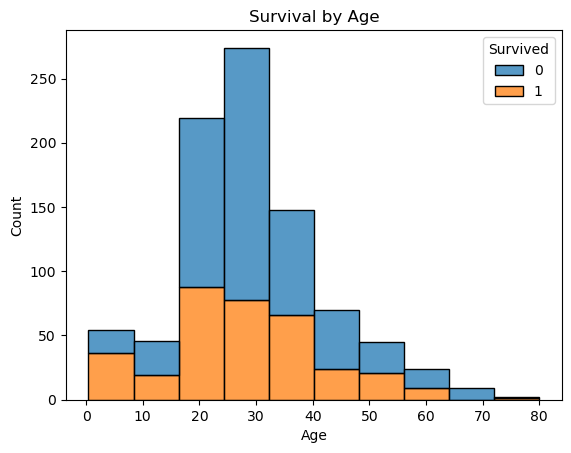

In [16]:
sns.histplot(data=data, x='Age', hue='Survived', multiple='stack', bins=10)
plt.title('Survival by Age')
plt.show()

## Using aif30

In [56]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric
from sklearn.linear_model import LogisticRegression
from aif360.algorithms.preprocessing import DisparateImpactRemover

In [18]:
train_data = X_train.copy()
train_data['Survived'] = y_train.values

test_data = X_test.copy()
test_data['Survived'] = y_test.values

privileged_groups = [{'Sex_male': 0}]
unprivileged_groups = [{'Sex_male': 1}]

In [19]:
train_dataset = BinaryLabelDataset(
    df=train_data, 
    label_names=['Survived'], 
    protected_attribute_names=['Sex_male'])

test_dataset = BinaryLabelDataset(
    df=test_data, 
    label_names=['Survived'],
    protected_attribute_names=['Sex_male'])

In [20]:
metric = BinaryLabelDatasetMetric(
    train_dataset, 
    unprivileged_groups=unprivileged_groups, 
    privileged_groups=privileged_groups)
print("Disparate impact = ", metric.disparate_impact())


Disparate impact =  0.2547285601888277


In [21]:
classifier = LogisticRegression(solver='liblinear')
classifier.fit(train_dataset.features, train_dataset.labels.ravel(),train_dataset.instance_weights)

LogisticRegression(solver='liblinear')

In [22]:
predictions = classifier.predict(test_dataset.features)
test_dataset_pred = test_dataset.copy(deepcopy=True)
test_dataset_pred.labels = predictions

In [23]:
accuracy = classifier.score(test_dataset.features, test_dataset.labels)
print("Accuracy: ", accuracy)

Accuracy:  0.8097014925373134


## Bias mitigation

#### Reweighing

In [24]:
rw = Reweighing(
    unprivileged_groups=unprivileged_groups, 
    privileged_groups=privileged_groups)
rw.fit(train_dataset)
train_dataset_transf = rw.transform(train_dataset)
test_dataset_transf = rw.transform(test_dataset)

In [25]:
classifier = LogisticRegression(solver='liblinear')
classifier.fit(train_dataset_transf.features, train_dataset_transf.labels.ravel(),train_dataset_transf.instance_weights)

LogisticRegression(solver='liblinear')

In [26]:
predictions = classifier.predict(test_dataset_transf.features)
test_dataset_pred = test_dataset_transf.copy(deepcopy=True)
test_dataset_pred.labels = predictions

In [27]:
metric_pred = BinaryLabelDatasetMetric(test_dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Disparate impact = ", metric_pred.disparate_impact())

Disparate impact =  1.2699282368822955


In [28]:
accuracy = classifier.score(test_dataset_transf.features, test_dataset_transf.labels)
print("Accuracy: ", accuracy)

Accuracy:  0.7089552238805971


#### DisparateImpactRemover

In [29]:
dir = DisparateImpactRemover(repair_level=1.0)
train_dataset_transf = dir.fit_transform(train_dataset)
test_dataset_transf = dir.fit_transform(test_dataset)

In [30]:
classifier = LogisticRegression(solver='liblinear')
classifier.fit(train_dataset_transf.features, train_dataset_transf.labels.ravel(),train_dataset_transf.instance_weights)

LogisticRegression(solver='liblinear')

In [31]:
predictions = classifier.predict(test_dataset_transf.features)
test_dataset_pred = test_dataset_transf.copy(deepcopy=True)
test_dataset_pred.labels = predictions

In [32]:
metric_pred = ClassificationMetric(test_dataset_transf, test_dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Disparate impact = ", metric_pred.disparate_impact())

Disparate impact =  0.0394428534235876


#### Learning Fair Representations

In [33]:
from aif360.algorithms.preprocessing import LFR

lfr = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=5, Ax=0.01, Ay=1.0, Az=2.0)
lfr.fit(train_dataset)
train_dataset_transf = lfr.transform(train_dataset)
test_dataset_transf = lfr.transform(test_dataset)

In [34]:
classifier = LogisticRegression(solver='liblinear')
classifier.fit(train_dataset_transf.features, train_dataset_transf.labels.ravel(),train_dataset_transf.instance_weights)

LogisticRegression(solver='liblinear')

In [35]:
predictions = classifier.predict(test_dataset_transf.features)
test_dataset_pred = test_dataset_transf.copy(deepcopy=True)
test_dataset_pred.labels = predictions
metric_pred = ClassificationMetric(test_dataset_transf, test_dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Disparate impact = ", metric_pred.disparate_impact())

Disparate impact =  0.49482852476864453


#### PrejudiceRemover

In [36]:
from aif360.algorithms.inprocessing import PrejudiceRemover

# Apply Prejudice Remover
pr = PrejudiceRemover(sensitive_attr='Sex_male', eta=25.0)
pr.fit(train_dataset)
train_dataset_transf = pr.predict(train_dataset)
test_dataset_transf = pr.predict(test_dataset)

In [37]:
classifier = LogisticRegression(solver='liblinear')
classifier.fit(train_dataset_transf.features, train_dataset_transf.labels.ravel(),train_dataset_transf.instance_weights)

LogisticRegression(solver='liblinear')

In [38]:
predictions = classifier.predict(test_dataset_transf.features)
test_dataset_pred = test_dataset_transf.copy(deepcopy=True)
test_dataset_pred.labels = predictions
metric_pred = ClassificationMetric(test_dataset_transf, test_dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Disparate impact = ", metric_pred.disparate_impact())

Disparate impact =  0.4233532934131736


#### RejectOptionClassification

In [39]:
from aif360.algorithms.postprocessing import RejectOptionClassification

# Train initial classifier
classifier = LogisticRegression(solver='liblinear')
classifier.fit(train_dataset.features, train_dataset.labels.ravel())

# Get predictions
predictions = classifier.predict(test_dataset.features)
test_dataset_pred = test_dataset.copy(deepcopy=True)
test_dataset_pred.labels = predictions

# Apply Reject Option Classification
roc = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
roc = roc.fit(test_dataset, test_dataset_pred)
test_dataset_transf_pred = roc.predict(test_dataset_pred)


In [40]:
classifier = LogisticRegression(solver='liblinear')
classifier.fit(train_dataset_transf.features, train_dataset_transf.labels.ravel())

LogisticRegression(solver='liblinear')

In [41]:
predictions = classifier.predict(test_dataset_transf.features)
test_dataset_pred = test_dataset_transf.copy(deepcopy=True)
test_dataset_pred.labels = predictions
metric_pred = ClassificationMetric(test_dataset_transf, test_dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Disparate impact = ", metric_pred.disparate_impact())

Disparate impact =  0.4233532934131736


#### Equalized odds postprocessing

In [42]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

In [43]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]
test_dataset_pred = test_dataset.copy()
test_dataset_pred.scores = y_pred_prob.reshape(-1, 1)

# Apply Equalized Odds Post-processing
cpp = EqOddsPostprocessing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

cpp = cpp.fit(test_dataset, test_dataset_pred)

# Transform the predictions
test_dataset_transformed_pred = cpp.predict(test_dataset_pred)
metric_pred = ClassificationMetric(
    test_dataset,
    test_dataset_transformed_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("Disparate impact after Equalized Odds Post-processing = ", metric_pred.disparate_impact())

Disparate impact after Equalized Odds Post-processing =  0.25587286964532474


#### Reject Option Classification

In [44]:
from aif360.algorithms.postprocessing import RejectOptionClassification

# Apply Reject Option Classification
roc = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
roc = roc.fit(test_dataset, test_dataset_pred)
test_dataset_transf_pred = roc.predict(test_dataset_pred)

classifier = LogisticRegression(solver='liblinear')
classifier.fit(train_dataset_transf.features, train_dataset_transf.labels.ravel())

predictions = classifier.predict(test_dataset_transf.features)
test_dataset_pred = test_dataset_transf.copy(deepcopy=True)
test_dataset_pred.labels = predictions
metric_pred = ClassificationMetric(test_dataset_transf, test_dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Disparate impact = ", metric_pred.disparate_impact())

Disparate impact =  0.4233532934131736


## for class variable

In [45]:
unprivileged_group2 = [{'Pclass_3': 1}]  # class 3 as unprivileged
privileged_group2 = [{'Pclass_3': 0}]  # class 1 and 2 as privileged

In [46]:
train_dataset = BinaryLabelDataset(
    df=train_data, 
    label_names=['Survived'], 
    protected_attribute_names=['Pclass_3'])

test_dataset = BinaryLabelDataset(
    df=test_data, 
    label_names=['Survived'],
    protected_attribute_names=['Pclass_3'])


In [47]:
metric = BinaryLabelDatasetMetric(
    train_dataset, 
    unprivileged_groups=unprivileged_group2, 
    privileged_groups=privileged_group2)
print("Disparate impact = ", metric.disparate_impact())


Disparate impact =  0.44822151307596514


In [48]:
rw = Reweighing(
    unprivileged_groups=unprivileged_group2, 
    privileged_groups=privileged_group2)
rw.fit(train_dataset)
train_dataset_transf = rw.transform(train_dataset)
test_dataset_transf = rw.transform(test_dataset)

In [49]:
classifier = LogisticRegression(solver='liblinear')
classifier.fit(train_dataset_transf.features, train_dataset_transf.labels.ravel(),train_dataset_transf.instance_weights)

LogisticRegression(solver='liblinear')

In [50]:
predictions = classifier.predict(test_dataset_transf.features)
test_dataset_pred = test_dataset_transf.copy(deepcopy=True)
test_dataset_pred.labels = predictions

In [51]:
metric_pred = BinaryLabelDatasetMetric(test_dataset_pred, unprivileged_groups=unprivileged_group2, privileged_groups=privileged_group2)
print("Disparate impact = ", metric_pred.disparate_impact())

Disparate impact =  0.7698234556769205
